BOOTH FUNCTION
$$f(x) = (x_1 + 2x_2 -7)^2 + (2x_1 + x_2 -5)^2$$

In [1]:
#Importar Librerias
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tkinter as tk
from tkinter import simpledialog, messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [2]:
def Funcion(x, y):
    #Definir Funcion
    z = (x + 2*y - 7)**2 + (2*x + y - 5)**2
    return z

def Gradiente(z, x, y):
    # Calcular gradiente
    grad_x = sp.diff(z, x)
    grad_y = sp.diff(z, y)
    grad = [grad_x, grad_y]
    return grad

def Hessiano(z, x, y):
    # Calcular hessiano
    hessiano = sp.hessian(z, (x, y))
    return hessiano

def Inversa(hessiano):
    # Calcular inversa
    inversa = hessiano.inv()
    return inversa

def line_search(f, x_k, p_k, grad_vector, symbols):
    alpha=1.0 
    rho=0.5 
    c=1e-4
    while True:
        new_x_k = x_k + alpha * p_k
        lhs = f.evalf(subs=dict(zip(symbols, new_x_k)))
        rhs = f.evalf(subs=dict(zip(symbols, x_k))) + c * alpha * grad_vector.dot(p_k)
        if lhs <= rhs:
            break
        alpha *= rho
    return alpha


In [3]:
#Definir Variables
x = sp.symbols('x')
y = sp.symbols('y')

z = Funcion(x, y)
print('Funcion: ', z)

grad = Gradiente(z, x, y)
print('Gradiente: ', grad)

hessiano = Hessiano(z, x, y)
print('Hessiano: ', hessiano)

Funcion:  (x + 2*y - 7)**2 + (2*x + y - 5)**2
Gradiente:  [10*x + 8*y - 34, 8*x + 10*y - 38]
Hessiano:  Matrix([[10, 8], [8, 10]])


In [4]:
#Metodo Gradiente Descendente
def GradienteDescendente(f, variables, initial_values, tol, max_iter):
    symbols = [sp.Symbol(var) for var in variables]
    gradient = Gradiente(f, x, y)
    x_k = sp.Matrix(initial_values)
    points = [x_k.tolist()] 
    
    for k in range(max_iter):
        grad_values = [grad.evalf(subs=dict(zip(symbols, x_k))) for grad in gradient]
        grad_vector = sp.Matrix(grad_values)
        if grad_vector.norm() < tol:
            print(f"se cumplio la tolerancia de Gradiente Descendente en la iteración {k}, con norma {grad_vector.norm()}")
            break
        p_k = -grad_vector
        alpha = line_search(f, x_k, p_k, grad_vector, symbols)
        x_k = x_k + alpha * p_k
        points.append(x_k.tolist()) 
    
    return x_k, points

#Metodo Newton
def Newton(f, variables, initial_values, tol, max_iter):
    symbols = [sp.Symbol(var) for var in variables]
    gradient = Gradiente(f, x, y)
    hessian = sp.hessian(f, symbols)
    x_k = sp.Matrix(initial_values)
    points = [x_k.tolist()]
    
    for k in range(max_iter):
        grad_values = [grad.evalf(subs=dict(zip(symbols, x_k))) for grad in gradient]
        grad_vector = sp.Matrix(grad_values)
        if grad_vector.norm() < tol:
            print(f"se cumplio la tolerancia de Newton en la iteración {k}, con norma {grad_vector.norm()}")
            break
        hessian_matrix = hessian.evalf(subs=dict(zip(symbols, x_k)))
        hessian_inv = hessian_matrix.inv()
        p_k = -hessian_inv * grad_vector
        alpha = line_search(f, x_k, p_k, grad_vector, symbols)
        x_k = x_k + alpha * p_k
        points.append(x_k.tolist())
    
    return x_k, points

def BFGS_update(B_k, s_k, y_k):
    Bs = B_k @ y_k
    yBs = y_k.T @ Bs

    syk = s_k.T @ y_k

    term1 = (1 + (yBs / syk)) * np.outer(s_k, s_k) / syk

    term2 = (np.outer(s_k, Bs.T) + np.outer(Bs, s_k.T)) / syk

    B_k1 = B_k + term1 - term2

    return B_k1

#Metodo de Quasi-Newton BFGS
def BFGS(f, variables, initial_values, tol, max_iter):
    symbols = [sp.Symbol(var) for var in variables]
    gradient = Gradiente(f, x, y)
    x_k = np.array(initial_values, dtype=float)
    B_k = np.eye(len(variables))
    points = [x_k.tolist()]

    for k in range(max_iter):
        grad_values = np.array([grad.evalf(subs=dict(zip(symbols, x_k.tolist()))) for grad in gradient], dtype=float)
        if np.linalg.norm(grad_values) < tol:
            print(f"se cumplio la tolerancia de BFGS en la iteración {k}, con norma {np.linalg.norm(grad_values)}")
            break
        
        p_k = -B_k @ grad_values
        
        alpha = line_search(f, x_k, p_k, grad_values, symbols)
        
        x_k1 = x_k + alpha * p_k
        
        s_k = x_k1 - x_k
        grad_values_k1 = np.array([grad.evalf(subs=dict(zip(symbols, x_k1.tolist()))) for grad in gradient], dtype=float)
        y_k = grad_values_k1 - grad_values

        B_k = BFGS_update(B_k, s_k, y_k)

        x_k = x_k1
        points.append(x_k.tolist())

    return x_k, points

#Metodo de Direcciones Conjugadas Powell
def powell(f,symbols, initial_values, tol, max_iter):
    x_k = np.array(initial_values, dtype=float)
    s = [np.array([1, 0]), np.array([0, 1])]
    points = [x_k.tolist()]
    gradient = Gradiente(f, x, y)
    grad_values = np.array([grad.evalf(subs=dict(zip(symbols, x_k.tolist()))) for grad in gradient], dtype=float)

    f_mas = f.evalf(subs=dict(zip(symbols, x_k + 0.001 * s[1])))
    f_menos = f.evalf(subs=dict(zip(symbols, x_k - 0.001 * s[1])))
    f_actual = f.evalf(subs=dict(zip(symbols, x_k)))
    if f_mas < f_actual:
        alpha = line_search(f, x_k + 0.001 * s[1], s[1], grad_values, symbols)
        x_k = x_k + alpha * s[1]
    elif f_menos < f_actual:
        alpha = line_search(f, x_k - 0.001 * s[1], -s[1], grad_values, symbols)
        x_k = x_k + alpha * (-s[1])

    for k in range(max_iter):
        z = np.copy(x_k)
        
        for i in range(len(s)):
            f_mas = f.evalf(subs=dict(zip(symbols, x_k + 0.001 * s[i])))
            f_menos = f.evalf(subs=dict(zip(symbols, x_k - 0.001 * s[i])))
            f_actual = f.evalf(subs=dict(zip(symbols, x_k)))

            if f_mas < f_actual:
                alpha = line_search(f, x_k + 0.001 * s[i], s[i], grad_values ,symbols)
                x_k = x_k + alpha * s[i]
            elif f_menos < f_actual:
                alpha = line_search(f, x_k - 0.001 * s[i], -s[i], grad_values, symbols)
                x_k = x_k + alpha * (-s[i])

        # Calcular la nueva dirección y realizar una búsqueda en esa dirección
        new_direction = x_k - z
        f_mas = f.evalf(subs=dict(zip(symbols, x_k + 0.001 * s[i])))
        f_menos = f.evalf(subs=dict(zip(symbols, x_k - 0.001 * s[i])))
        f_actual = f.evalf(subs=dict(zip(symbols, x_k)))
        if f_mas < f_actual:
            alpha = line_search(f, x_k + 0.001 * new_direction, new_direction, grad_values, symbols)
            x_k = x_k + alpha * new_direction
        elif f_menos < f_actual:
            alpha = line_search(f, x_k - 0.001 * new_direction, -new_direction, grad_values, symbols)
            x_k = x_k + alpha * (-new_direction)

        if np.linalg.norm(new_direction) > tol:
            alpha = line_search(f, x_k, new_direction, grad_values, symbols)
            x_k = x_k + alpha * new_direction

        if np.linalg.norm(new_direction) < tol:
            print(f"se cumplio la tolerancia de Powell en la iteración {k}, con norma {np.linalg.norm(new_direction)}")
            break
        points.append(x_k.tolist())
        s.append(new_direction)
        s.pop(0)

    return x_k, points

In [5]:
def graficar_gui(points, Metodo, root):
    x_center, y_center = 1, 3
    x_range, y_range = 5, 5
    x_min, x_max = x_center - x_range, x_center + x_range
    y_min, y_max = y_center - y_range, y_center + y_range

    step_size = 0.1
    x = np.arange(x_min, x_max, step_size)
    y = np.arange(y_min, y_max, step_size)
    X, Y = np.meshgrid(x, y)

    Z = Funcion(X, Y)

    levels = np.arange(0, 100, 5)

    new_window = tk.Toplevel(root)
    new_window.title(f"Gráfica del Método {Metodo}")

    fig, ax = plt.subplots()
    contours = ax.contour(X, Y, Z, levels=levels)
    ax.plot(points[:, 0], points[:, 1], 'ro-')
    ax.set_title(f'Curvas de nivel - {Metodo}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True)
    ax.legend([Metodo])

    canvas = FigureCanvasTkAgg(fig, master=new_window)
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    canvas.draw()

se cumplio la tolerancia de Gradiente Descendente en la iteración 45, con norma 5.49905728670490E-8
se cumplio la tolerancia de Newton en la iteración 1, con norma 0E-123
se cumplio la tolerancia de BFGS en la iteración 7, con norma 3.722165991082178e-09
se cumplio la tolerancia de Powell en la iteración 4, con norma 0.0


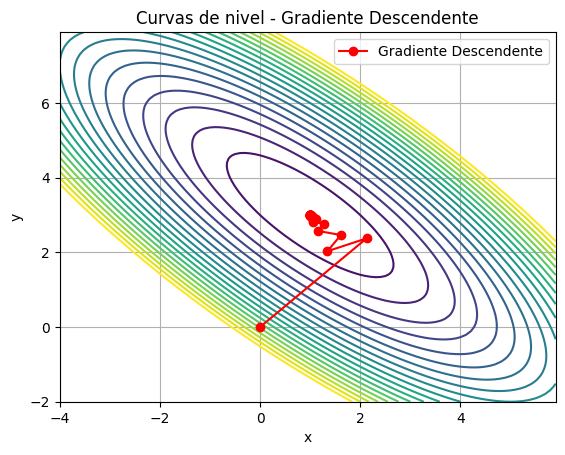

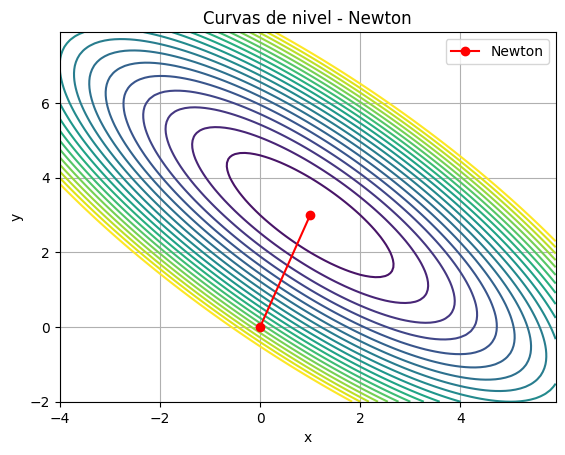

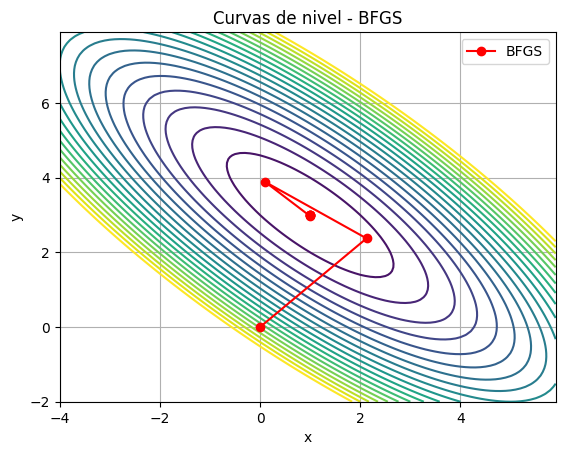

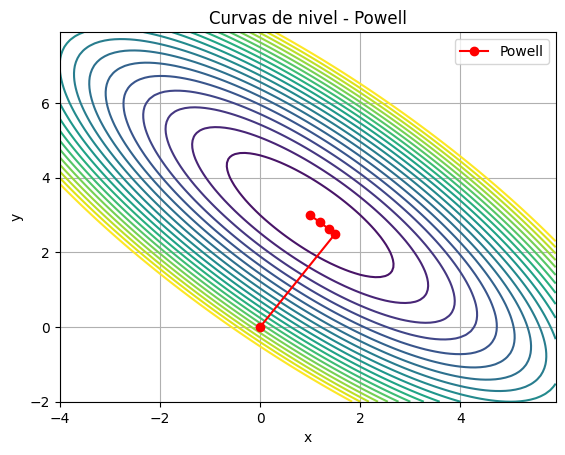

In [6]:
def mostrar_resultados(result, points, root, metodos):
    result_str = f"Resultado del {metodos}: x = {result[0]}, y = {result[1]}"
    messagebox.showinfo(f"Resultado del {metodos}", result_str)
    graficar_gui(points, metodos, root)

def ejecutar_metodo(metodo, initial_values, tol, n,root):
    if metodo == '1':
        result, points_grad = GradienteDescendente(z, ['x', 'y'], initial_values, tol, n)
        points = np.array(points_grad)
        mostrar_resultados(result, points, root, 'Gradiente Descendente')
    elif metodo == '2':
        result, points_new = Newton(z, ['x', 'y'], initial_values, tol, n)
        points = np.array(points_new)
        mostrar_resultados(result, points, root, 'Newton')
    elif metodo == '3':
        result, points_bfgs = BFGS(z, ['x', 'y'], initial_values, tol, n)
        points = np.array(points_bfgs)
        mostrar_resultados(result, points, root, 'BFGS')
    elif metodo == '4':
        result, points_pow = powell(z, ['x', 'y'], initial_values, tol, n)
        points = np.array(points_pow)
        mostrar_resultados(result, points, root, 'Powell')
    elif metodo == '5':
        ejecutar_y_mostrar_todos_los_metodos(initial_values, tol, n, root)
    else:
        messagebox.showerror("Error", "Opción no válida. Por favor, selecciona una opción válida.")

def ejecutar_y_mostrar_todos_los_metodos(initial_values, tol, n, root):
    metodos = {
        '1': GradienteDescendente,
        '2': Newton,
        '3': BFGS,
        '4': powell
    }
    nombres_metodos = {
        '1': "Gradiente Descendente",
        '2': "Newton",
        '3': "BFGS",
        '4': "Powell"
    }

    for metodo in metodos:
        result, points = metodos[metodo](z, ['x', 'y'], initial_values, tol, n)
        points = np.array(points)
        mostrar_todos_resultados(result, points, root, nombres_metodos[metodo])

def mostrar_todos_resultados(result, points, root, metodo):
    result_str = f"Resultado del {metodo}: x = {result[0]}, y = {result[1]}"
    messagebox.showinfo(f"Resultado del {metodo}", result_str)
    graficar_gui(points, metodo, root)


def solicitar_parametros(metodo, root):
    initial_values = simpledialog.askstring("Input", "Ingrese la solución inicial separado por coma:")
    tol = float(simpledialog.askstring("Input", "Ingrese la tolerancia:"))
    n = int(simpledialog.askstring("Input", "Ingrese el número máximo de iteraciones:"))
    initial_values_n = [float(value) for value in initial_values.split(',')]
    ejecutar_metodo(metodo, initial_values_n, tol, n,root)

def cerrar_aplicacion(root):
    for window in root.winfo_children():
        window.destroy()
    root.destroy()

root = tk.Tk()
root.title("Optimización de Métodos Iterativos")
root.geometry("800x600")

label = tk.Label(root, text="Seleccione un método de optimización:")
label.pack(pady=10)

metodos = [
    ("1. Metodo de Gradiente Descendente", '1'),
    ("2. Metodo de Newton", '2'),
    ("3. Metodo de BFGS", '3'),
    ("4. Metodo de Powell", '4'),
    ("5. Mostrar todos", '5')
]

metodo_var = tk.StringVar()
metodo_var.set('1')

for texto, valor in metodos:
    rb = tk.Radiobutton(root, text=texto, variable=metodo_var, value=valor)
    rb.pack(anchor=tk.W)


button = tk.Button(root, text="Ejecutar", command=lambda: solicitar_parametros(metodo_var.get(), root))
button.pack(pady=20)

button_salir = tk.Button(root, text="Salir", command=lambda: cerrar_aplicacion(root))
button_salir.pack(pady=10)


root.protocol("WM_DELETE_WINDOW", lambda: cerrar_aplicacion(root))

root.mainloop()